# Fig. 10

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import xarray as xr 
import seaborn as sns
import matplotlib.lines as mlines
plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size': 20})

import warnings
warnings.filterwarnings("ignore")

## Functions

In [2]:
def another_mask(ds, cutoff, dlat=0.3, dlon=0.5, use_tracer=True):
    """
    Applies a mask to the dataset based on latitude, longitude, and a threshold quantile height.

    Parameters:
    ds (xarray.Dataset): The dataset to be masked.
    cutoff (float): The threshold factor for determining the mask.
    dlat (float): The latitude range around -36° for the mask (default is 0.3).
    dlon (float): The longitude range around 146.5° for the mask (default is 0.5).
    use_tracer (bool): If True, use the "Qpassive_1" tracer for calculation; otherwise, use density (default is True).

    Returns:
    xarray.Dataset: The dataset with an additional 'ao_mask' variable.
    """
    # Apply the initial geographical mask based on latitude and longitude
    ds_masked = ds.where(
        (ds.lat >= -36 - dlat) & (ds.lat <= -36 + dlat) & 
        (ds.lon >= 146.5 - dlon) & (ds.lon <= 146.5 + dlon),
        other=np.nan
    )

    # Apply the mask based on quantile height (5th percentile)
    ds_masked2 = ds_masked.where(
        ds.height > quantile_height(ds, quantile=0.05),
        other=np.nan
    )

    # Calculate flux based on the tracer or density
    if use_tracer:
        qflux = ds_masked2["w_intp"] * ds_masked2["Qpassive_1"]
    else:
        qflux = ds_masked2["w_intp"] * dens(ds_masked2)

    # Determine the maximum flux and apply the cutoff factor
    qmax = qflux.max(("lon", "lat"))
    threshold = qmax * cutoff
    aomask = qflux > threshold

    # Assign the mask to the dataset
    ds['ao_mask'] = (("time", "height", "lat", "lon"), aomask.data)

    return ds

def quantile_height(ds, var="Qpassive_1", quantile=0.05):
    """
    Calculates the height above which a specified quantile percentage of the given variable are located.
    Primarily used with 'Qpassive_1' to determine the injection height.

    Parameters:
    ds (xarray.Dataset): The dataset containing the variable of interest.
    var (str): The variable name to use for calculation (default is "Qpassive_1").
    quantile (float): The quantile value (e.g., 0.05 for 5%) to determine the height threshold (default is 0.05).

    Returns:
    xarray.DataArray: The minimum height where the specified quantile condition is met.
    """
    
    ds = ds.mean(("lat", "lon"))
    rho = dens(ds)
    dz = -1 * z.differentiate("height")
    qplume = ds[var] * rho.values * dz.values
    qplume_sum = qplume.cumsum(dim="height")
    qplume_100 = qplume_sum.max(dim="height")
    qplume_q = qplume_100 * quantile
    height_q = ds['height'].where(qplume_q < qplume_sum)
    height_q_min = height_q.min(dim="height")

    return height_q_min


def dens(d): 
    R = 287.1
    densitiy = d.pres / (R * d.temp)
    return densitiy



def cloud_base(dset):
    """
    Finds the cloud base height where the 'qc' variable exceeds a certain threshold.

    Parameters:
    dset (xarray.Dataset): The dataset containing the 'qc' variable and a mask called 'inner_mask'.

    Returns:
    xarray.DataArray: The height at which 'qc' exceeds the threshold.
    """
    # Apply the mask to the dataset
    dset = dset.where(dset.ao_mask, np.nan)

    # Calculate the mean across the 'lon' and 'lat' dimensions
    data = dset.mean(("lon", "lat"))

    # Find 'qc' values that exceed the threshold (0.0002)
    qc_above_threshold = data['qc'].where(data['qc'] > 0.0004).values

    # Find the indices where 'qc' is not NaN
    valid_indices = np.where(~np.isnan(qc_above_threshold))

    # Find the highest valid index for the cloud base
    if valid_indices[0].size > 0:  # Ensure there is a valid index
        highest_index = np.max(valid_indices)
        highest_height = dset.height.isel(height=highest_index)
    else:
        highest_height = np.nan  # Return NaN if no valid index is found

    return highest_height



def more_vars(ds):
    """
    Calculates additional thermodynamic variables and adds them to the dataset.

    Parameters:
    ds (xarray.Dataset): The dataset containing temperature and water vapor data.

    Returns:
    xarray.Dataset: The original dataset with additional variables for analysis.
    """
    # Constants for calculations
    p0 = 1000  # Reference pressure in hPa
    lv_const_a = 2500.78  # Latent heat constant (a)
    lv_const_b = 2.32573  # Latent heat constant (b)
    Rd = 287.04  # Specific gas constant for dry air (J/(kg·K))
    cp = 1004.82  # Specific heat capacity at constant pressure (J/(kg·K))
    cw = 4186.74  # Specific heat capacity of water (J/(kg·K))

    # Calculate the mixing ratio of water vapor
    r = ds.qv / (1 - ds.qv)

    # Calculate the latent heat of vaporization (lv)
    lv = lv_const_a - (ds.temp * lv_const_b)

    # Calculate equivalent potential temperature (theta_ae)
    theta_ae = (ds.temp + r * (lv / (cp + r * cw))) * ((p0 / ds.pres) ** (Rd / cp))
    ds["theta_ae"] = theta_ae

    # Calculate potential temperature (tpot)
    tpot = ds.temp * ((p0 / ds.pres) ** (Rd / cp))
    ds["tpot"] = tpot

    # Add the mixing ratio as a variable to the dataset
    ds["r"] = r

    # Calculate and add density to the dataset
    ds["dens"] = dens(ds)

    # Calculate total water content and condensed water content
    ds["qtotal"] = ds.qc + ds.qi + ds.qg + ds.qs + ds.qh + ds.qr + ds.qv
    ds["qcondens"] = ds.qc + ds.qi + ds.qg + ds.qs + ds.qh + ds.qr

    return ds

In [3]:
def override_height(ds, z):
    return ds.assign_coords(height=z.values)

## Get Data

In [4]:
data_path = "../data/"
dsref = xr.open_mfdataset(data_path + "exp_ref.nc", engine = 'netcdf4').isel(time = slice(2,None)).mean("time").squeeze()
z = xr.open_mfdataset("./height_info.nc").mean("time").squeeze().mean(("lat", "lon"))["z_mc"]/1000
z = z.assign_coords(height=dsref.height)
dsref = override_height(dsref,z)

In [5]:
cut = 0.05

#75
ds10 = override_height(xr.open_mfdataset(data_path + "exp_010.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
ds11 = override_height(xr.open_mfdataset(data_path + "exp_011.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
ds12 = override_height(xr.open_mfdataset(data_path + "exp_012.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
ds13 = override_height(xr.open_mfdataset(data_path + "exp_013.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
list75 = [ds10, ds11, ds12, ds13]



#100
ds14 = override_height(xr.open_mfdataset(data_path + "exp_014.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
ds15 = override_height(xr.open_mfdataset(data_path + "exp_015.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
ds16 = override_height(xr.open_mfdataset(data_path + "exp_016.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
ds17 = override_height(xr.open_mfdataset(data_path + "exp_017.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
list100 = [ds14, ds15, ds16, ds17]



#150
ds18 = override_height(xr.open_mfdataset(data_path + "exp_018.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
ds19 = override_height(xr.open_mfdataset(data_path + "exp_019.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
ds20 = override_height(xr.open_mfdataset(data_path + "exp_020.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
ds21 = override_height(xr.open_mfdataset(data_path + "exp_021.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
list150 = [ds18, ds19, ds20, ds21]



#200
ds25 = override_height(xr.open_mfdataset(data_path + "exp_025.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
ds26 = override_height(xr.open_mfdataset(data_path + "exp_026.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
ds27 = override_height(xr.open_mfdataset(data_path + "exp_027.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
ds28 = override_height(xr.open_mfdataset(data_path + "exp_028.nc", engine = 'netcdf4').isel(time = slice(3,None)).squeeze(),z)
list200 = [ds25, ds26, ds27, ds28]




dsets = [ ds10, ds11, ds12, ds13, ds14, ds15, ds16, ds17, ds18, ds19, ds20, ds21,ds25, ds26, ds27, ds28 ]
for ds in dsets:
    ds = more_vars(ds)
    ds = another_mask(ds, cut)

list_of_lists = [list75 ,list100, list150, list200]


## Prepare Plot

In [6]:
cb_data = [
    np.array([cloud_base(ds) for ds in axis]) 
    for axis in list_of_lists
]

In [7]:
# Calculate Error
indices = np.searchsorted(dsref.height.compute()[::-1], cb_data)
upper_error = (dsref.height.values[indices] - dsref.height.values[indices+1]) * 0.5  
lower_error = (dsref.height.values[indices-1] - dsref.height.values[indices]) * 0.5

In [8]:
group_colors = [ "#483D8B", "#B22222", "#2E8B57", "#fbc740"]
steps = ["30%","20%", "10%","0%"]
total_fluxes = [50, 100, 150, 200]
sets_names = [ f"75$\,$kW", f"100$\,$kW", f"150$\,$kW",f"200$\,$kW"]

In [9]:
n_groups = np.array(cb_data).shape[1]
n_bars = np.array(cb_data).shape[0]

In [10]:
y_ticks = np.arange(4,5.1,0.1)
bar_width = 0.18
index = np.arange(n_groups)

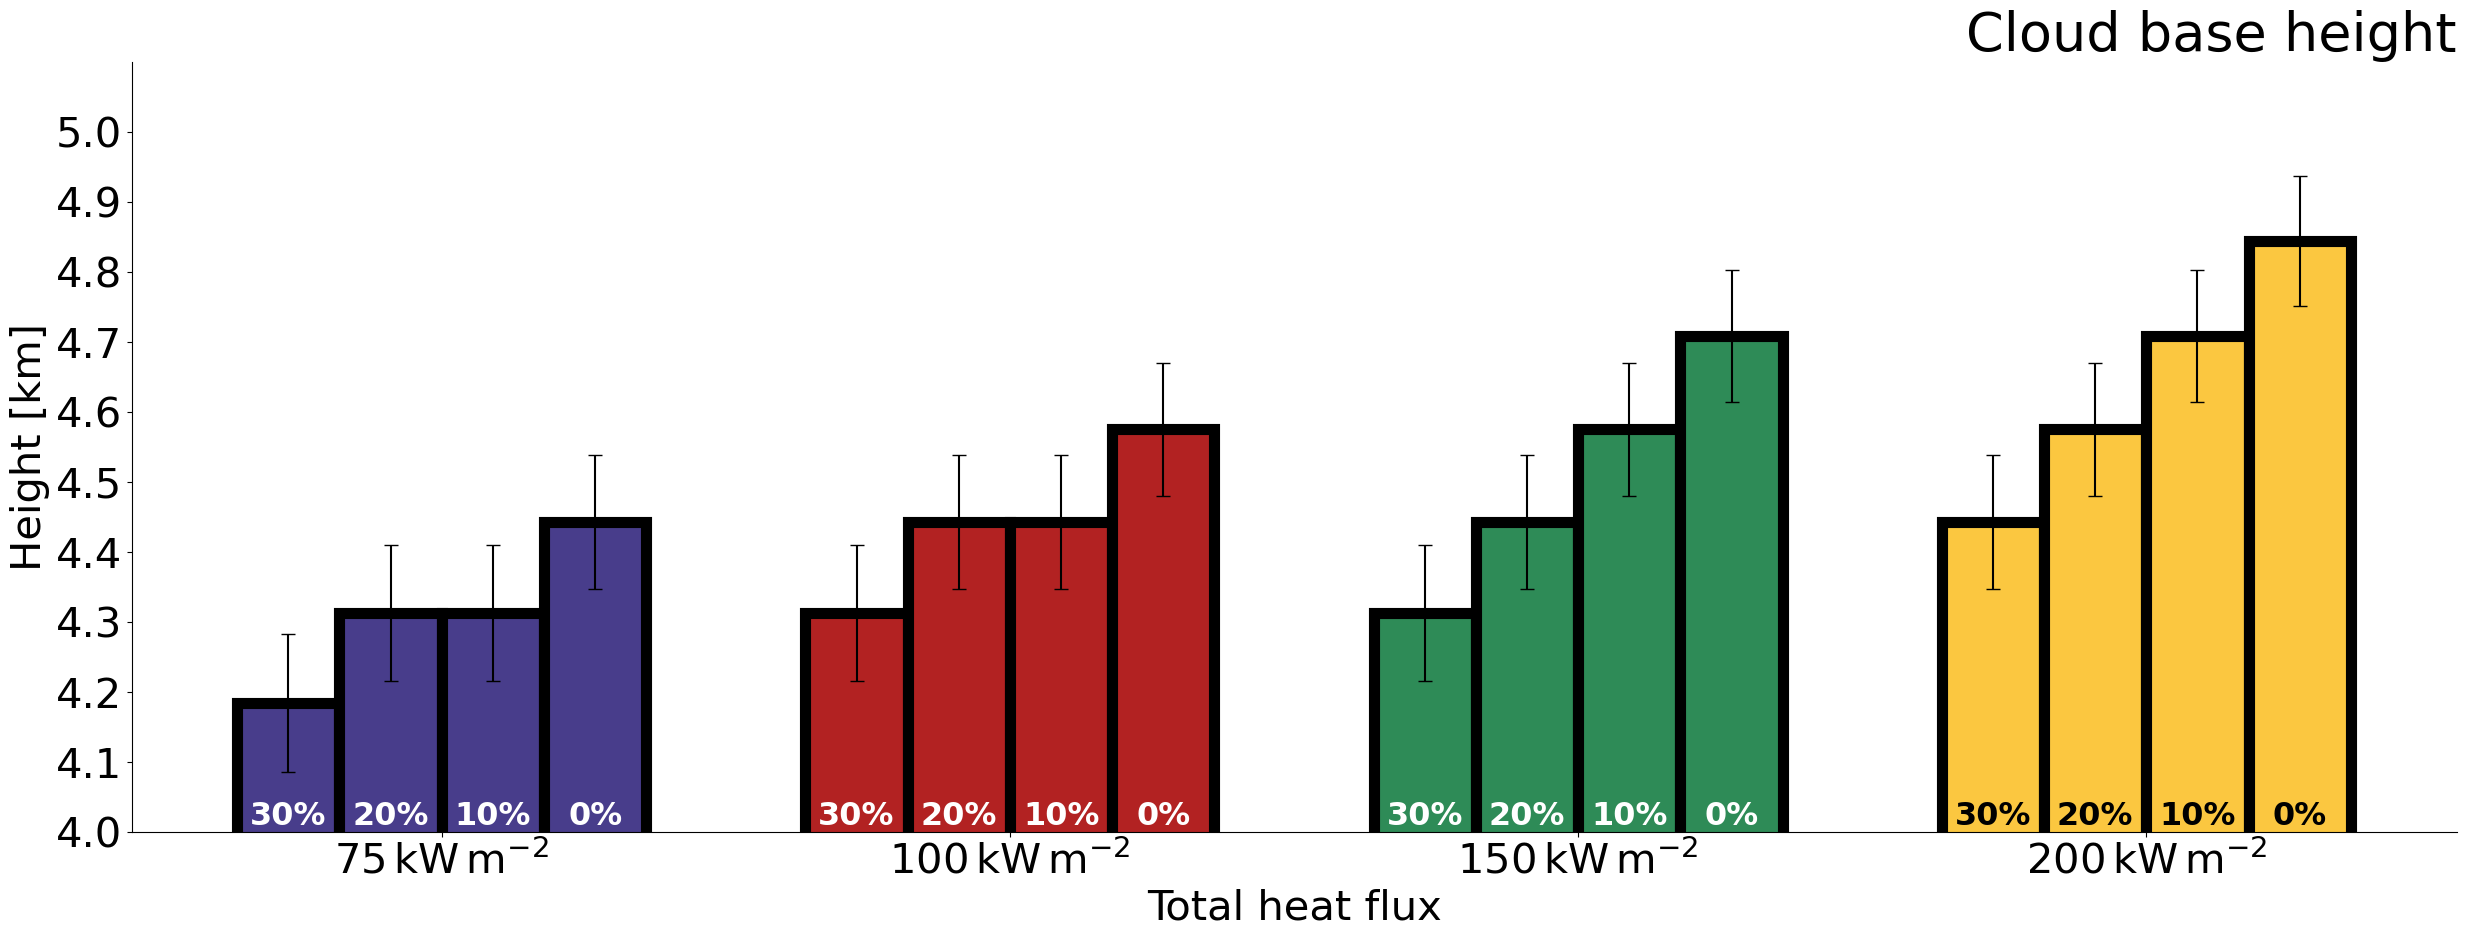

In [11]:
fig, ax = plt.subplots(1, 1, figsize=[30, 10])
# Labels inside each group
bar_labels = ['30%', '20%', '10%', '0%']
bar_text_color= ["white", "white", "white", "black"]
sets_names = [ f"75$\,$kW$\,$m$^{{-2}}$", f"100$\,$kW$\,$m$^{{-2}}$", f"150$\,$kW$\,$m$^{{-2}}$",f"200$\,$kW$\,$m$^{{-2}}$"]
#ax.grid(True, axis='y' )

for i in range(n_groups):
    # Plot all bars in the same group with the same color
    for j in range(n_bars):
        error_range = [[ lower_error[j][i]],  # Lower error
                [upper_error[j][i]]]  # Upper error
                                                              
        ax.bar(index[i] + j * bar_width, cb_data[j][i]-1, bar_width, color=group_colors[i % len(group_colors)], edgecolor='black', linewidth = 8, bottom=1, yerr = error_range, capsize=5)

# Add labels above the bars
        ax.text(index[i] + j * bar_width, 4,  # Position above the bar
                bar_labels[j], 
                ha='center', va='bottom', fontsize=23, fontweight = "bold", color = bar_text_color[i])


# Adding labels and title
ax.set_xlabel('Total heat flux', fontsize=30)
ax.set_ylabel('Height [km]', fontsize=30)
ax.set_title('Cloud base height', loc = "right", fontsize = 39)

# Setting the x-ticks as the group names
ax.set_xticks(index + bar_width * (n_bars - 1) / 2)
ax.set_xticklabels(sets_names, fontsize=30)
ax.set_ylim(4,5.1)

ax.set_yticks(y_ticks)
ax.set_yticklabels(np.round(y_ticks,2), fontsize = 30)


sns.despine(ax=ax)

my_path = "./figs/"
fig.savefig(my_path + 'fig10.png', dpi=300, bbox_inches='tight')
fig.savefig(my_path + 'fig10_lq.png', dpi=50, bbox_inches='tight')

